In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm

We define a complex MLP

In [2]:
# Define the model
class SimpleNN(nn.Module):
  def setup(self):
    self.dense1 = nn.Dense(features=32)
    self.dense2 = nn.Dense(features=2)

  def __call__(self, x):
    x = self.dense1(x)
    x = nn.gelu(x)
    x = self.dense2(x)
    return x

# Learning Functions over Projective Spaces

Projective spaces are defined by:
$$
\mathbb{P}_n = \frac{\mathbb{C}^{n+1} - \{\vec{0}\}}{\mathbb{C}^\ast}
$$

That is, we consider $(\mathbb{C}^{n+1})$, remove the origin, and identify up to a non-zero complex rescaling $(\vec{z} \sim \lambda \vec{z})$, with $(\vec{z} \in \mathbb{C}^{n+1} - \{\vec{0}\})$ and $\
\lambda \in \mathbb{C}^\ast)$.

A function over projective space is required to be invariant under projective rescalings:
$$
f(\vec{z}) = f(\lambda \vec{z}) \quad \forall \vec{z}, \lambda
$$

In [3]:
import pickle
with open("funcData.pkl", "rb") as f:
    inputs, outputs = pickle.load(f)

print(inputs[0],outputs[0])

[ 0.19395497 -1.7570837  -0.00396011 -0.44197065] [-0.22134964  0.10380346]


This data set is for a function on $\mathbb{P}_1$, and outputs a complex number $x+iy$, represented by $[x,y]$. The input is listed as $[\text{Re}(Z_0), \text{Re}(Z_1), \text{Im}(Z_0), \text{Im}(Z_1)]$.

100%|██████████| 1000/1000 [00:01<00:00, 756.28it/s]


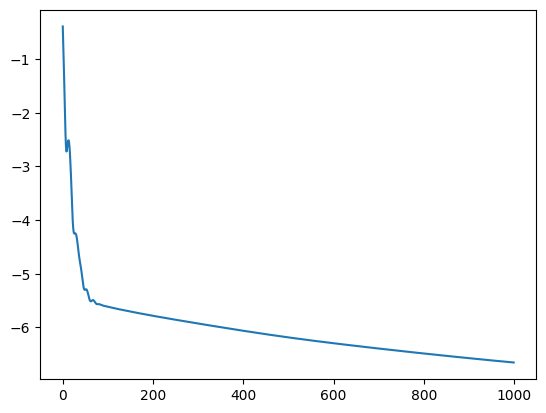

In [4]:
# Generate some training data
key = jax.random.PRNGKey(0)
x_train = inputs
y_train = outputs

# Initialise the model and optimiser
model = SimpleNN()
params = model.init(jax.random.PRNGKey(1), x_train)
optimiser = optax.adam(learning_rate=0.01)
my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser)

# Define the loss function
def loss_fn(params, x, y):
  y_pred = model.apply(params, x)
  loss = jnp.mean((y_pred - y) ** 2)
  return loss

# Define the training step
@jax.jit
def train_step(state, x, y):
  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state.params, x, y)
  state = state.apply_gradients(grads=grads)
  return state, loss

# Train the model
loss = []
for i in tqdm(range(1000)):
  my_state, l = train_step(my_state, x_train, y_train)
  loss.append(jnp.log(l))

plt.plot(loss)
plt.show()

**Exercise:**

1. Check how close this NN is to being invariant under the projective rescaling.
2. Try to design a NN that is invariant under this projective rescaling.
3. Train that NN on the dataset, and compare the results.

In [5]:
#1. Just demonstrate real scaling here 
model.apply(my_state.params, x_train[500]), model.apply(my_state.params, 2*x_train[500])

(Array([0.18234333, 0.20361365], dtype=float32),
 Array([0.26518375, 0.19513823], dtype=float32))

In [6]:
#Now the complex rescaling
angle = 0.5
cos_val = jnp.cos(angle)
sin_val = jnp.sin(angle)
#matOut = jnp.array([[cos_val, -sin_val], [sin_val,  cos_val]])
matIn = jnp.array([[cos_val ,0. ,-sin_val, 0.],
                   [0. ,cos_val, 0., -sin_val],
                   [sin_val, 0., cos_val, 0.],
                   [0., sin_val, 0., cos_val]])
print(matIn)

[[ 0.87758255  0.         -0.47942555  0.        ]
 [ 0.          0.87758255  0.         -0.47942555]
 [ 0.47942555  0.          0.87758255  0.        ]
 [ 0.          0.47942555  0.          0.87758255]]


In [7]:
model.apply(my_state.params, x_train[500]), model.apply(my_state.params, jnp.dot(matIn,x_train[500]))

(Array([0.18234333, 0.20361365], dtype=float32),
 Array([0.20822412, 0.22123234], dtype=float32))

In [8]:
# Define the model
class Func(nn.Module):
  def setup(self):
    self.dense1 = nn.Dense(features=32)
    self.dense2 = nn.Dense(features=2)

  def __call__(self, x):
    kappa = jnp.sum(jnp.square(x))
    x = jnp.array([x[0]**2 + x[2]**2,
                   x[1]**2 + x[3]**2,
                   x[0]*x[1]+x[2]*x[3],
                   x[0]*x[3]-x[1]*x[2]])/kappa

    x = self.dense1(x)
    x = nn.gelu(x)
    x = self.dense2(x)
    return x

100%|██████████| 1000/1000 [00:01<00:00, 698.09it/s]


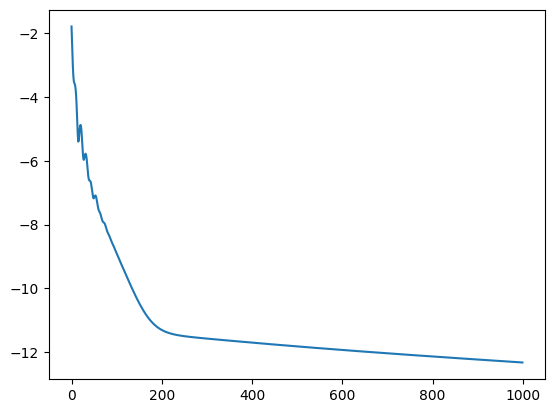

In [9]:
# Get training data
x_train = inputs
y_train = outputs

# Initialise the model and optimiser
model = Func()
params = model.init(jax.random.PRNGKey(1), x_train[0])
optimiser = optax.adam(learning_rate=0.01)
my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser)

# Define the loss function
def loss_fn(params, x, y):
  y_pred = jax.vmap(model.apply,in_axes=(None,0))(params,x)
  loss = jnp.mean((y_pred - y) ** 2)
  return loss

# Define the training step
@jax.jit
def train_step(state, x, y):
  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state.params, x, y)
  state = state.apply_gradients(grads=grads)
  return state, loss

# Train the model
loss = []
for i in tqdm(range(1000)):
  my_state, l = train_step(my_state, x_train, y_train)
  loss.append(jnp.log(l))

plt.plot(loss)
plt.show()

In [10]:
#3. Again, have just checked the real scaling here
model.apply(my_state.params, x_train[500]), model.apply(my_state.params, 2*x_train[500])

(Array([0.23307435, 0.20334375], dtype=float32),
 Array([0.23307435, 0.20334375], dtype=float32))

In [11]:
#Now the complex rescaling
angle = 0.5
cos_val = jnp.cos(angle)
sin_val = jnp.sin(angle)
#matOut = jnp.array([[cos_val, -sin_val], [sin_val,  cos_val]])
matIn = jnp.array([[cos_val ,0. ,-sin_val, 0.],
                   [0. ,cos_val, 0., -sin_val],
                   [sin_val, 0., cos_val, 0.],
                   [0., sin_val, 0., cos_val]])
print(matIn)

[[ 0.87758255  0.         -0.47942555  0.        ]
 [ 0.          0.87758255  0.         -0.47942555]
 [ 0.47942555  0.          0.87758255  0.        ]
 [ 0.          0.47942555  0.          0.87758255]]


In [12]:
model.apply(my_state.params, x_train[500]), model.apply(my_state.params, jnp.dot(matIn,x_train[500]))

(Array([0.23307435, 0.20334375], dtype=float32),
 Array([0.23307435, 0.20334375], dtype=float32))

# Learning Sections of Line Bundles over Projective Spaces

We can learn sections of line bundles over projective spaces—don't worry if you don't know what a line bundle is.

For $\mathbb{P}_1$, we label a line bundle as $O(k)$, with $k \in \mathbb{Z}$.

A section of this line bundle transforms under projective rescalings as:
$$
\sigma(\lambda \vec{Z}) = \lambda^{k_4} \sigma(\vec{Z})
$$

In [13]:
import pickle
with open("sectData.pkl", "rb") as f:
    inputs, outputs = pickle.load(f)

print(inputs[0],outputs[0])

[ 1.1597246   1.2696937  -0.55691326  0.20402706] [ 0.02591452 -0.33085796]


This dataset is for a section of $O(2)$.

The input is listed the same as last time, and the output is $[\text{Re}(\sigma), \text{Im}(\sigma)]$.

Let's train a NN to learn this section.

100%|██████████| 1000/1000 [00:01<00:00, 740.34it/s]


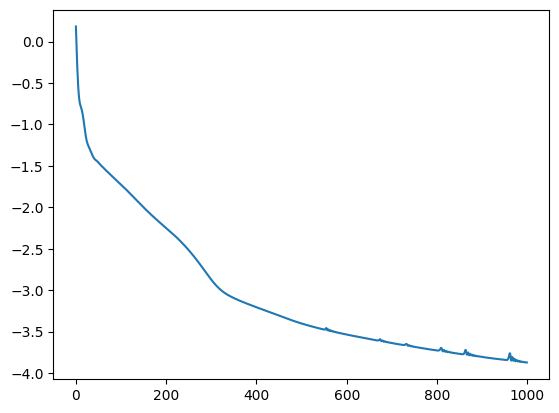

In [14]:
# Generate some training data
key = jax.random.PRNGKey(0)
x_train = inputs
y_train = outputs

# Initialise the model and optimiser
model = SimpleNN()
params = model.init(jax.random.PRNGKey(1), x_train)
optimiser = optax.adam(learning_rate=0.01)
my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser)

# Define the loss function
def loss_fn(params, x, y):
  y_pred = model.apply(params, x)
  loss = jnp.mean((y_pred - y) ** 2)
  return loss

# Define the training step
@jax.jit
def train_step(state, x, y):
  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state.params, x, y)
  state = state.apply_gradients(grads=grads)
  return state, loss

# Train the model
loss = []
for i in tqdm(range(1000)):
  my_state, l = train_step(my_state, x_train, y_train)
  loss.append(jnp.log(l))

plt.plot(loss)
plt.show()

**Exercise:**

1. Check how close this NN is to being invariant under the projective rescaling.
2. Try to design a NN that is appropriately equivariant under this projective rescaling.
3. Train that NN on the dataset, and compare the results.

In [15]:
#1. Again, just checked the real scaling here
print(model.apply(my_state.params, x_train[500]), model.apply(my_state.params, 2*x_train[500]),
model.apply(my_state.params, 2*x_train[500]) / model.apply(my_state.params, x_train[500]))


[-0.25326842 -0.46906585] [-0.4751991 -1.4166726] [1.8762667 3.0201998]


In [16]:
#Now the complex rescaling
angle = 0.5
cos_val = jnp.cos(angle)
sin_val = jnp.sin(angle)
matOut = jnp.array([[cos_val, -sin_val], [sin_val,  cos_val]])
matIn = jnp.array([[cos_val ,0. ,-sin_val, 0.],
                   [0. ,cos_val, 0., -sin_val],
                   [sin_val, 0., cos_val, 0.],
                   [0., sin_val, 0., cos_val]])
print(matIn)

[[ 0.87758255  0.         -0.47942555  0.        ]
 [ 0.          0.87758255  0.         -0.47942555]
 [ 0.47942555  0.          0.87758255  0.        ]
 [ 0.          0.47942555  0.          0.87758255]]


In [17]:
input = x_train[500]
output = model.apply(my_state.params, x_train[500])

print(input,output,y_train[500])

[-0.25326842 -0.46906585] [ 0.24589474 -0.42561954]
[-0.16834328 -0.36203265] [ 0.21368372 -0.33726305]


In [ ]:
transformIn = jnp.dot(matIn,input)
transformOut = jnp.dot(matOut,jnp.dot(matOut,output))

print(model.apply(my_state.params, transformIn),transformOut)

In [18]:
# Define the model
class Sections(nn.Module):
  def setup(self):
    self.dense1 = nn.Dense(features=32)
    self.dense2 = nn.Dense(features=3)

  def __call__(self, x):
    kappa = jnp.sum(jnp.square(x))

    out = jnp.array([ [ x[0]**2 - x[2]**2,     #Re(x0^2)
                     x[0]*x[1]-x[2]*x[3],   #Re(x0 x1)
                     x[1]**2 - x[3]**2 ],     #Re(x1^2)

                     [ 2*x[0]*x[2],          #Im(x0^2)
                     x[0]*x[3]+x[1]*x[2],  #Im(x0 x1)
                     2*x[1]*x[3] ] ])         #Im(x1^2)

    x = jnp.array([x[0]**2 + x[2]**2,
                   x[1]**2 + x[3]**2,
                   x[0]*x[1]+x[2]*x[3],
                   x[0]*x[3]-x[1]*x[2]])/kappa

    x = self.dense1(x)
    x = nn.gelu(x)
    x = self.dense2(x)
    x = jnp.dot(out,x)
    return x 

100%|██████████| 1000/1000 [00:01<00:00, 500.93it/s]


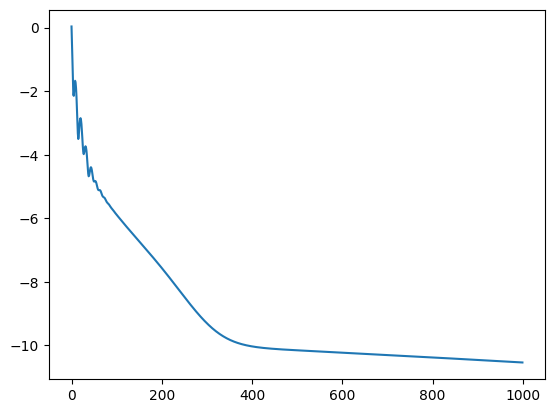

In [19]:
# Get training data
x_train = inputs
y_train = outputs

# Initialise the model and optimiser
model = Sections()
params = model.init(jax.random.PRNGKey(1), x_train[0])
optimiser = optax.adam(learning_rate=0.01)
my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser)

# Define the loss function
def loss_fn(params, x, y):
  y_pred = jax.vmap(model.apply,in_axes=(None,0))(params,x)
  loss = jnp.mean((y_pred - y) ** 2)
  return loss

# Define the training step
@jax.jit
def train_step(state, x, y):
  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state.params, x, y)
  state = state.apply_gradients(grads=grads)
  return state, loss

# Train the model
loss = []
for i in tqdm(range(1000)):
  my_state, l = train_step(my_state, x_train, y_train)
  loss.append(jnp.log(l))

plt.plot(loss)
plt.show()

In [20]:
#1. Again, just checked the real scaling here
print(model.apply(my_state.params, x_train[500]), model.apply(my_state.params, 2*x_train[500]),
model.apply(my_state.params, 2*x_train[500]) / model.apply(my_state.params, x_train[500]))

[-0.17426188 -0.35850617] [-0.69704753 -1.4340247 ] [4. 4.]


In [21]:
#Now the complex rescaling
angle = 0.5
cos_val = jnp.cos(angle)
sin_val = jnp.sin(angle)
matOut = jnp.array([[cos_val, -sin_val], [sin_val,  cos_val]])
matIn = jnp.array([[cos_val ,0. ,-sin_val, 0.],
                   [0. ,cos_val, 0., -sin_val],
                   [sin_val, 0., cos_val, 0.],
                   [0., sin_val, 0., cos_val]])
print(matIn)
print(matOut)

[[ 0.87758255  0.         -0.47942555  0.        ]
 [ 0.          0.87758255  0.         -0.47942555]
 [ 0.47942555  0.          0.87758255  0.        ]
 [ 0.          0.47942555  0.          0.87758255]]
[[ 0.87758255 -0.47942555]
 [ 0.47942555  0.87758255]]


In [22]:
input = x_train[500]
output = model.apply(my_state.params, x_train[500])

print(input,output,y_train[500])

[ 0.00679903  0.6128359  -1.8685743  -0.16649443] [-0.17426188 -0.35850617] [-0.16834328 -0.36203265]


In [23]:
transformIn = jnp.dot(matIn,input)
transformOut = jnp.dot(matOut,jnp.dot(matOut,output))

print(model.apply(my_state.params, transformIn),transformOut)

[ 0.20751838 -0.3403381 ] [ 0.20751846 -0.34033802]
